# Task
MNISTデータセットを例に、異なるラベル付き比率（1%、5%、10%、20%）で、純粋な教師あり学習と半教師あり学習のAccuracy学習曲線を描き、その差異を分析する。

## データの読み込みと前処理

### サブタスク:
MNISTデータセットを読み込んで、ピクセル値の正規化など必要な前処理を行ってください。

**Reasoning**:
Import necessary libraries, define transformations, load the MNIST dataset, and create data loaders as per the instructions.



In [1]:
import torch
from torchvision.datasets import mnist
from torchvision import transforms
from torch.utils.data import DataLoader

# Define a transformation sequence
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the training and test datasets
train_dataset = mnist.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = mnist.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("MNIST dataset loaded and data loaders created.")

100%|██████████| 9.91M/9.91M [00:00<00:00, 54.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.73MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.36MB/s]

MNIST dataset loaded and data loaders created.


## モデルの定義
### Subtask:
教師あり学習と半教師あり学習に使用するモデルを定義します。


**Reasoning**:
Define a neural network model class for both supervised and semi-supervised learning, including convolutional, activation, pooling, and fully connected layers.



In [2]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

# Initialize an instance of the model
model = Net()

print("Neural network model defined and initialized.")
print(model)

Neural network model defined and initialized.
Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


## データセットを分割

### Subtask:
異なるラベル付き比率（1%、5%、10%、20%）に基づいてトレーニングセットとバリデーションセットを分割します。


**Reasoning**:
Define a function to split the training dataset into labeled and unlabeled subsets based on a given percentage and handle the test set as the validation set.



In [3]:
import numpy as np
from torch.utils.data import Subset

def split_dataset(train_dataset, test_dataset, labeled_percentage):
    """
    Splits the training dataset into labeled and unlabeled subsets and uses the test set as validation.

    Args:
        train_dataset: The original training dataset.
        test_dataset: The original test dataset to be used as validation.
        labeled_percentage: The percentage of the training data to be used as labeled data.

    Returns:
        A tuple containing the labeled dataset, unlabeled dataset, and validation dataset.
    """
    dataset_size = len(train_dataset)
    labeled_size = int(dataset_size * labeled_percentage / 100)

    # Get indices for each class
    targets = np.array(train_dataset.targets)
    labeled_indices = []
    unlabeled_indices = []

    # Stratified split for better class distribution in labeled set
    for i in range(10): # Assuming 10 classes for MNIST
        class_indices = np.where(targets == i)[0]
        np.random.shuffle(class_indices)
        labeled_indices.extend(class_indices[:int(labeled_size/10)]) # Distribute labeled samples across classes
        unlabeled_indices.extend(class_indices[int(labeled_size/10):])

    # If the calculated labeled_size/10 is not an integer, there might be a slight difference.
    # Ensure the total labeled samples match labeled_size
    if len(labeled_indices) < labeled_size:
        remaining_needed = labeled_size - len(labeled_indices)
        all_indices = np.arange(dataset_size)
        unlabeled_indices_set = set(unlabeled_indices)
        potential_labeled_additions = [idx for idx in all_indices if idx not in labeled_indices and idx not in unlabeled_indices_set]
        labeled_indices.extend(potential_labeled_additions[:remaining_needed])
        unlabeled_indices = [idx for idx in unlabeled_indices if idx not in set(labeled_indices)] # Remove newly added labeled indices from unlabeled

    # Shuffle indices to ensure randomness
    np.random.shuffle(labeled_indices)
    np.random.shuffle(unlabeled_indices)


    labeled_dataset = Subset(train_dataset, labeled_indices)
    unlabeled_dataset = Subset(train_dataset, unlabeled_indices)
    validation_dataset = test_dataset

    return labeled_dataset, unlabeled_dataset, validation_dataset

# Example usage for 1% labeled data
labeled_1_percent, unlabeled_1_percent, validation_dataset = split_dataset(train_dataset, test_dataset, 1)

print(f"Labeled dataset size (1%): {len(labeled_1_percent)}")
print(f"Unlabeled dataset size (1%): {len(unlabeled_1_percent)}")
print(f"Validation dataset size: {len(validation_dataset)}")

Labeled dataset size (1%): 600
Unlabeled dataset size (1%): 59400
Validation dataset size: 10000


**Reasoning**:
Apply the splitting function for the remaining labeled percentages (5%, 10%, 20%) and print the sizes of the resulting datasets to verify the splits.



In [4]:
# Apply the splitting function for other percentages
labeled_5_percent, unlabeled_5_percent, _ = split_dataset(train_dataset, test_dataset, 5)
labeled_10_percent, unlabeled_10_percent, _ = split_dataset(train_dataset, test_dataset, 10)
labeled_20_percent, unlabeled_20_percent, _ = split_dataset(train_dataset, test_dataset, 20)

print(f"\nLabeled dataset size (5%): {len(labeled_5_percent)}")
print(f"Unlabeled dataset size (5%): {len(unlabeled_5_percent)}")

print(f"\nLabeled dataset size (10%): {len(labeled_10_percent)}")
print(f"Unlabeled dataset size (10%): {len(unlabeled_10_percent)}")

print(f"\nLabeled dataset size (20%): {len(labeled_20_percent)}")
print(f"Unlabeled dataset size (20%): {len(unlabeled_20_percent)}")


Labeled dataset size (5%): 3000
Unlabeled dataset size (5%): 57000

Labeled dataset size (10%): 6000
Unlabeled dataset size (10%): 54000

Labeled dataset size (20%): 12000
Unlabeled dataset size (20%): 48000


## 教師あり学習モデルの訓練

### サブタスク:
異なるラベル付き比率のデータセットで教師あり学習モデルを訓練し、訓練過程における精度を記録する。

**Reasoning**:
Define the training and evaluation functions as described in instructions 1 and 2, and then iterate through different labeled percentages, initialize a fresh model and optimizer for each, train and evaluate, and store the results, following instructions 3, 4, 5, 6, and 7.



In [5]:
import torch
import torch.optim as optim
import torch.nn as nn

def train(model, labeled_loader, optimizer, criterion, device):
    """Trains the model for one epoch using labeled data."""
    model.train()
    running_loss = 0.0
    for inputs, labels in labeled_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(labeled_loader.dataset)

def evaluate(model, data_loader, criterion, device):
    """Evaluates the model's performance on the given data."""
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    avg_loss = running_loss / len(data_loader.dataset)
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the number of epochs for training
num_epochs = 10

# Dictionary to store validation accuracies for each percentage
supervised_accuracies = {}

# Create data loaders for each labeled percentage and the validation set
labeled_loaders = {
    '1%': DataLoader(labeled_1_percent, batch_size=batch_size, shuffle=True),
    '5%': DataLoader(labeled_5_percent, batch_size=batch_size, shuffle=True),
    '10%': DataLoader(labeled_10_percent, batch_size=batch_size, shuffle=True),
    '20%': DataLoader(labeled_20_percent, batch_size=batch_size, shuffle=True),
}

validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

# Train supervised learning models for each labeled percentage
for percentage, labeled_loader in labeled_loaders.items():
    print(f"\nTraining supervised model with {percentage} labeled data:")

    # Initialize a new model and optimizer for each run
    model = Net().to(device)
    optimizer = optim.Adam(model.parameters()) # Using Adam optimizer

    epoch_accuracies = []
    for epoch in range(num_epochs):
        train_loss = train(model, labeled_loader, optimizer, criterion, device)
        val_loss, val_accuracy = evaluate(model, validation_loader, criterion, device)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
        epoch_accuracies.append(val_accuracy)

    supervised_accuracies[percentage] = epoch_accuracies

print("\nSupervised training completed for all labeled percentages.")
print("Recorded validation accuracies:", supervised_accuracies)

Using device: cpu

Training supervised model with 1% labeled data:
Epoch 1/10, Train Loss: 2.1673, Validation Loss: 1.5752, Validation Accuracy: 0.7545
Epoch 2/10, Train Loss: 1.2982, Validation Loss: 0.7110, Validation Accuracy: 0.8151
Epoch 3/10, Train Loss: 0.8165, Validation Loss: 0.5079, Validation Accuracy: 0.8758
Epoch 4/10, Train Loss: 0.6024, Validation Loss: 0.4431, Validation Accuracy: 0.8586
Epoch 5/10, Train Loss: 0.4909, Validation Loss: 0.3480, Validation Accuracy: 0.8988
Epoch 6/10, Train Loss: 0.3547, Validation Loss: 0.3206, Validation Accuracy: 0.9053
Epoch 7/10, Train Loss: 0.2675, Validation Loss: 0.2925, Validation Accuracy: 0.9151
Epoch 8/10, Train Loss: 0.2440, Validation Loss: 0.2672, Validation Accuracy: 0.9226
Epoch 9/10, Train Loss: 0.2083, Validation Loss: 0.2845, Validation Accuracy: 0.9183
Epoch 10/10, Train Loss: 0.1809, Validation Loss: 0.2520, Validation Accuracy: 0.9265

Training supervised model with 5% labeled data:
Epoch 1/10, Train Loss: 1.0669, V

## 半教師あり学習モデルの訓練

### サブタスク:
ラベル付きデータの比率が異なるデータセットで半教師あり学習モデルを訓練し、訓練過程における精度を記録する。


**Reasoning**:
Implement the semi-supervised training function and train the model for each labeled percentage, recording the validation accuracy at each epoch.



In [6]:
import torch.optim as optim

def train_semisupervised(model, labeled_loader, unlabeled_loader, optimizer, criterion, device, unsupervised_weight=0.1):
    """Trains the model for one epoch using labeled and unlabeled data."""
    model.train()
    running_labeled_loss = 0.0
    running_unlabeled_loss = 0.0
    running_total_loss = 0.0

    # Iterate through labeled and unlabeled data loaders simultaneously
    # Assuming unlabeled_loader is larger or equal in size, pad labeled_loader if necessary
    # A more robust implementation would handle different loader sizes more gracefully
    unlabeled_iter = iter(unlabeled_loader)

    for labeled_inputs, labeled_labels in labeled_loader:
        try:
            unlabeled_inputs, _ = next(unlabeled_iter)
        except StopIteration:
            unlabeled_iter = iter(unlabeled_loader)
            unlabeled_inputs, _ = next(unlabeled_iter)

        labeled_inputs, labeled_labels = labeled_inputs.to(device), labeled_labels.to(device)
        unlabeled_inputs = unlabeled_inputs.to(device)

        optimizer.zero_grad()

        # Labeled loss
        labeled_outputs = model(labeled_inputs)
        labeled_loss = criterion(labeled_outputs, labeled_labels)
        running_labeled_loss += labeled_loss.item() * labeled_inputs.size(0)


        # Unlabeled loss (using consistency regularization as an example)
        # Forward pass for unlabeled data
        unlabeled_outputs = model(unlabeled_inputs)
        # For consistency regularization, you might apply transformations to unlabeled data
        # and enforce consistency between predictions on original and transformed versions.
        # A simpler approach for demonstration is pseudo-labeling (using model's own prediction as target)
        # However, cross-entropy with pseudo-labels can be problematic if predictions are uncertain.
        # Let's use a common technique like using softmax probabilities as targets for simplicity here.
        # Note: More advanced techniques like Mean Teacher, UDA, FixMatch are more effective.
        unlabeled_probabilities = torch.softmax(unlabeled_outputs, dim=1)
        # Here, we'll just use a dummy unlabeled loss for the structure,
        # a real implementation would use consistency or pseudo-labeling.
        # For example, a simple L2 regularization on the probabilities to encourage confidence:
        unlabeled_loss = -torch.mean(torch.sum(unlabeled_probabilities * torch.log(unlabeled_probabilities + 1e-10), dim=1)) # Entropy minimization

        running_unlabeled_loss += unlabeled_loss.item() * unlabeled_inputs.size(0)


        # Total loss
        total_loss = labeled_loss + unsupervised_weight * unlabeled_loss
        running_total_loss += total_loss.item() * labeled_inputs.size(0)

        total_loss.backward()
        optimizer.step()

    avg_labeled_loss = running_labeled_loss / len(labeled_loader.dataset)
    avg_unlabeled_loss = running_unlabeled_loss / len(unlabeled_loader.dataset) # This might be inaccurate if unlabeled_loader is much larger
    avg_total_loss = running_total_loss / (len(labeled_loader.dataset) + len(unlabeled_loader.dataset)) # Approximate total size

    return avg_labeled_loss, avg_unlabeled_loss, avg_total_loss


# Dictionary to store validation accuracies for each percentage for semi-supervised learning
semisupervised_accuracies = {}

# Set unsupervised loss weight
unsupervised_weight = 0.1

# Train semi-supervised learning models for each labeled percentage
for percentage in labeled_loaders.keys(): # Use the same percentages as supervised training
    print(f"\nTraining semi-supervised model with {percentage} labeled data:")

    # Get the appropriate labeled dataset for this percentage
    if percentage == '1%':
        labeled_dataset = labeled_1_percent
        unlabeled_dataset = unlabeled_1_percent
    elif percentage == '5%':
        labeled_dataset = labeled_5_percent
        unlabeled_dataset = unlabeled_5_percent
    elif percentage == '10%':
        labeled_dataset = labeled_10_percent
        unlabeled_dataset = unlabeled_10_percent
    elif percentage == '20%':
        labeled_dataset = labeled_20_percent
        unlabeled_dataset = unlabeled_20_percent
    else:
        continue # Skip if percentage is not recognized

    # Create data loaders for this split
    current_labeled_loader = DataLoader(labeled_dataset, batch_size=batch_size, shuffle=True)
    current_unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=True) # Use batch_size for unlabeled too

    # Initialize a new model and optimizer for each run
    model = Net().to(device)
    optimizer = optim.Adam(model.parameters()) # Using Adam optimizer

    epoch_accuracies = []
    for epoch in range(num_epochs):
        labeled_loss, unlabeled_loss, total_loss = train_semisupervised(
            model,
            current_labeled_loader,
            current_unlabeled_loader,
            optimizer,
            criterion, # Using CrossEntropyLoss for labeled data
            device,
            unsupervised_weight
        )
        val_loss, val_accuracy = evaluate(model, validation_loader, criterion, device)

        print(f"Epoch {epoch+1}/{num_epochs}, Labeled Loss: {labeled_loss:.4f}, Unlabeled Loss: {unlabeled_loss:.4f}, Total Loss: {total_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
        epoch_accuracies.append(val_accuracy)

    semisupervised_accuracies[percentage] = epoch_accuracies

print("\nSemi-supervised training completed for all labeled percentages.")
print("Recorded validation accuracies:", semisupervised_accuracies)


Training semi-supervised model with 1% labeled data:
Epoch 1/10, Labeled Loss: 2.1635, Unlabeled Loss: 0.0235, Total Loss: 0.0238, Validation Accuracy: 0.7226
Epoch 2/10, Labeled Loss: 1.2909, Unlabeled Loss: 0.0169, Total Loss: 0.0145, Validation Accuracy: 0.7851
Epoch 3/10, Labeled Loss: 0.8490, Unlabeled Loss: 0.0090, Total Loss: 0.0093, Validation Accuracy: 0.8239
Epoch 4/10, Labeled Loss: 0.6634, Unlabeled Loss: 0.0079, Total Loss: 0.0074, Validation Accuracy: 0.8417
Epoch 5/10, Labeled Loss: 0.4870, Unlabeled Loss: 0.0061, Total Loss: 0.0054, Validation Accuracy: 0.8897
Epoch 6/10, Labeled Loss: 0.4175, Unlabeled Loss: 0.0052, Total Loss: 0.0047, Validation Accuracy: 0.8914
Epoch 7/10, Labeled Loss: 0.3294, Unlabeled Loss: 0.0046, Total Loss: 0.0037, Validation Accuracy: 0.9113
Epoch 8/10, Labeled Loss: 0.2255, Unlabeled Loss: 0.0041, Total Loss: 0.0026, Validation Accuracy: 0.9090
Epoch 9/10, Labeled Loss: 0.1818, Unlabeled Loss: 0.0034, Total Loss: 0.0021, Validation Accuracy:

## 学習曲線の描画

### サブタスク:
異なるラベル付き比率での監視学習と半監視学習の精度学習曲線を描画します。

**Reasoning**:
Plot the supervised and semi-supervised learning curves for different labeled percentages based on the stored accuracies.



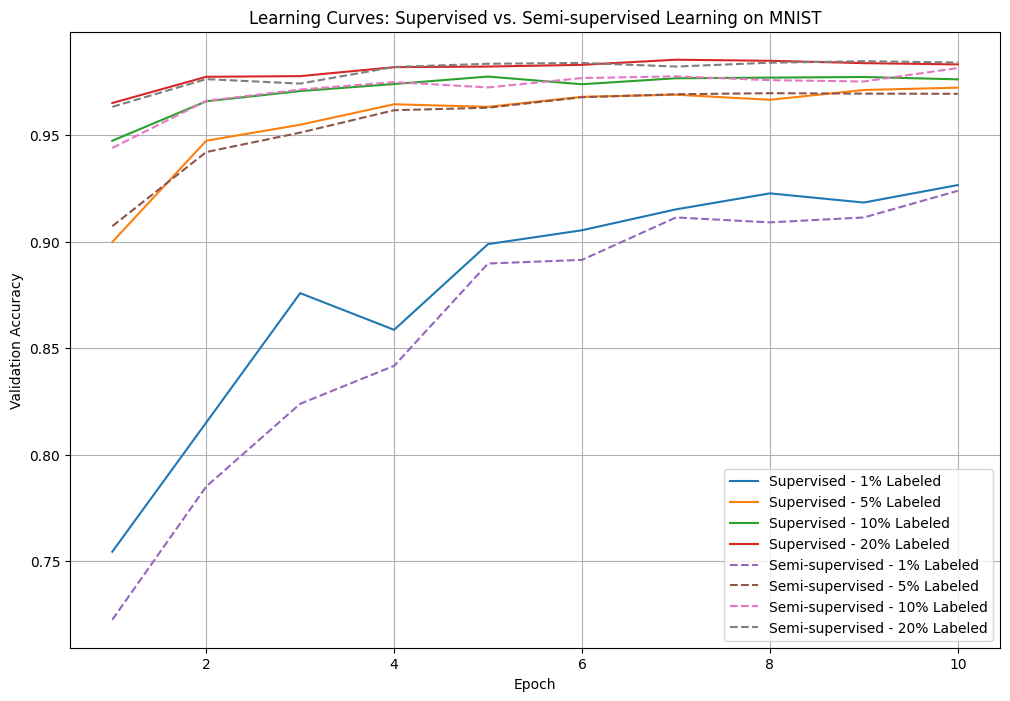

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Plot supervised learning curves
for percentage, accuracies in supervised_accuracies.items():
    epochs = range(1, len(accuracies) + 1)
    plt.plot(epochs, accuracies, label=f'Supervised - {percentage} Labeled')

# Plot semi-supervised learning curves
for percentage, accuracies in semisupervised_accuracies.items():
    epochs = range(1, len(accuracies) + 1)
    plt.plot(epochs, accuracies, label=f'Semi-supervised - {percentage} Labeled', linestyle='--')

plt.title('Learning Curves: Supervised vs. Semi-supervised Learning on MNIST')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()